In [2]:
##Run the below block to initialize all the dependencies
import requests
from pprint import pprint
import pandas as pd
from pandas import ExcelWriter
import io, time, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import scipy
import warnings
warnings.filterwarnings("ignore")

In [5]:
##The below block of code is used to read the API Key required for extracting data from Yelp fusion API.

def read_api_key(filepath):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    
    with open('api_key.txt', 'r') as f:
        return f.read().replace('\n','')

def read_api_key_zomato(filepath):
    """
    Read the Yelp API Key from file.
    
    Args:
        filepath (string): File containing API Key
    Returns:
        api_key (string): The API Key
    """
    
    with open('api_key_zomato.txt', 'r') as f:
        return f.read().replace('\n','')

In [6]:
##The function below is used to retrieve all the restaurants from the YELP API.

def all_restaurants(api_key, query):
    """
    Retrieve ALL the restaurants on Yelp for a given query.

    Args:
        query (string): Search term

    Returns:
        results (list): list of dicts representing each business
    """
    
    offsetno=0
    total =0
    output=[]
    headers = {        
        "authorization": 'Bearer %s' % api_key, # for the yelp API     
    }
    while (offsetno < 1000):
        params = { #parameters are case sensitive!
            "location": query,
            "limit": 20,
            "offset": offsetno,
            "categories": "restaurants"
            
        }
    
        response = requests.get('https://api.yelp.com/v3/businesses/search',
                            headers=headers, params=params)
        result = response.json()
        try:
            output.append( result['businesses'])
        except KeyError:
            print(result)
            return output
        offsetno =offsetno + 20
        total = result['total']
        #print (offsetno)
        #print (len(output))
    return(output)

api_key = read_api_key('api_key.txt')
data = all_restaurants(api_key, 'Miami')
new_data = {}
new_data["name"]=[]
new_data["rating"]=[]
new_data["price"]=[]
new_data["review_count"]=[]
new_data["url"]=[]
new_data["category"]=[]
new_data["zip"]=[]
new_data["Source"]=[]
alldata=[]
for i in data:
    for each in i:
        new_data["name"].append(each["name"])
        new_data["rating"].append(each["rating"])
        new_data["url"].append(each["url"])
        try:
            new_data["price"].append(each["price"])
        except KeyError:
            new_data["price"].append(None)

        new_data["review_count"].append(each["review_count"])
        new_data["category"].append(each["categories"][0]["title"])
        new_data["zip"].append(each["location"]["zip_code"])
        new_data["Source"].append('Yelp')
        alldata.append(each)
writer = pd.ExcelWriter('../DataFiles/Final_Data.xlsx' , engine='xlsxwriter')
yelp_raw = pd.DataFrame(alldata)
yelp_clean = pd.DataFrame(new_data)

In [35]:
##The below code needs to be executed to clean the TripAdvisor CSV file and create a raw and clean dataset out of it.

trip_advisor_raw = pd.read_csv('../DataFiles/TripAdvisor_Data.csv')
trip_advisor_clean = trip_advisor_raw[trip_advisor_raw["City"]=="Miami"]
trip_advisor_clean = trip_advisor_clean.loc[:,["Restaurant ID", "Restaurant URL","Name","Address","Ranking","Total Review"]]
trip_advisor_clean['Source'] = 'Trip Advisor'

In [53]:
##Below block of code is used to extract the data from the Zomato API.

api_key_zomato = read_api_key_zomato('api_key_zomato.txt')

headers = {'Content-Type': 'application/json', 'user-key': api_key_zomato}
offset = 0
restaurantNameList = []
ratingList = []
ratingTextList = []
votesList = []
totalData = []
urlList = []
addressList = []
sourceList = []
while offset < 100:
    url = 'https://developers.zomato.com/api/v2.1/search?entity_id=291&entity_type=city&start='+str(offset)+'&count=20'
    Response = requests.get(url , headers=headers)
    offset += 20
    Response_Json = Response.json()
    Array_length = Response_Json['restaurants']
    for i in range(len(Array_length)):
        totalData.append(Response_Json['restaurants'][i])
        restaurantNameList.append(Response_Json['restaurants'][i]['restaurant']['name'])
        ratingList.append(Response_Json['restaurants'][i]['restaurant']['user_rating']['aggregate_rating'])
        ratingTextList.append(Response_Json['restaurants'][i]['restaurant']['user_rating']['rating_text'])
        votesList.append(Response_Json['restaurants'][i]['restaurant']['user_rating']['votes'])
        urlList.append(Response_Json['restaurants'][i]['restaurant']['url'])
        addressList.append(Response_Json['restaurants'][i]['restaurant']['location']['address'])
        sourceList.append('Zomato')
zomato_raw = pd.DataFrame({'AllData':totalData})
zomato_clean = pd.DataFrame({'Restaurant Name':restaurantNameList,'Rating':ratingList, 'Rating Text':ratingTextList, 'Votes':votesList, 'Url':urlList, 'Address': addressList, 'Source': sourceList})



In [54]:
##Run the below block to create the excel file with the collated data

writer = pd.ExcelWriter('../DataFiles/Final_Data.xlsx' , engine='xlsxwriter')

yelp_raw.to_excel(writer,'Yelp_Raw',index=False)
yelp_clean.to_excel(writer,'Yelp_Clean',index=False)
trip_advisor_raw.to_excel(writer, sheet_name = ' TripAdvisor_Raw')
trip_advisor_clean.to_excel(writer, sheet_name = 'TripAdvisor_Clean')
zomato_raw.to_excel(writer,sheet_name = 'Zomato_Raw')
zomato_clean.to_excel(writer,sheet_name = 'Zomato_Clean')

writer.save()
writer.close()

In [ ]:
##We have to write the code for merging all the data frames.




In [55]:
##Below is the code for the visualizations.
##We read the data data sheet created above below.

data = pd.ExcelFile('../DataFiles/Final_Data.xlsx')

In [83]:
##Parsing the clean sheets below

zomato = data.parse('Zomato_Clean')
yelp = data.parse('Yelp_Clean')
ta = data.parse('TripAdvisor_Clean')

In [84]:
ta.head()
ta.shape

(1248, 7)

In [85]:
zomato.head(5)
zomato.shape

(100, 7)

In [94]:
yelp.head(5)
yelp.shape

(1000, 8)

yelp.columns

In [87]:
zomato.columns = ['address', 'rating', 'rating Text', 'name', 'url', 'votes','Source']

In [88]:
ta.columns = ['restaurantID', 'restaurantURL', 'name', 'address', 'ranking','Total Review','Source']

Cross tabulation charts

# Yelp Restaurant Category and Rating

Zomato Rating

In [89]:
bins = [0, 0.5, 1.0, 1.5, 2, 2.5, 3, 3.5, 4.0, 4.5, 5.0]

zomato['ratingbucket'] = pd.cut(zomato['rating'], bins)

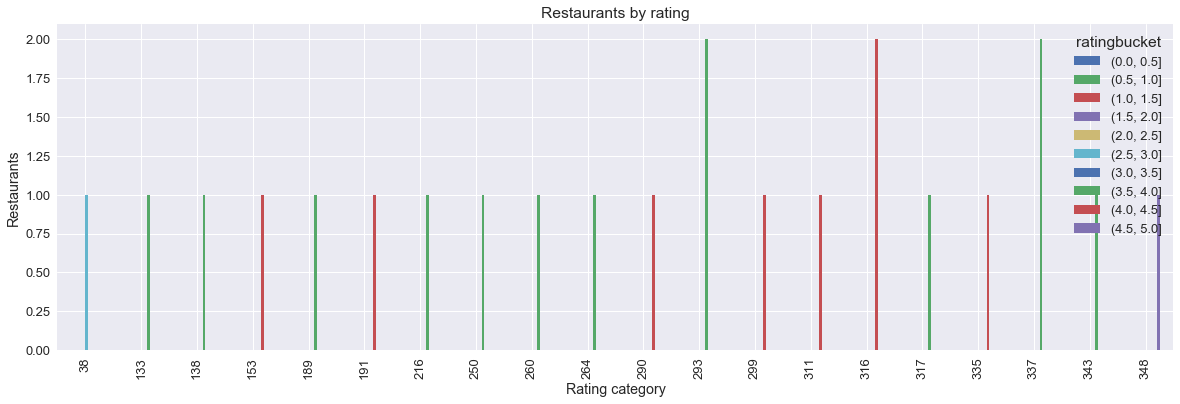

In [90]:
zomato = zomato.sort_values('rating', ascending=False)

sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20,6))
pd.crosstab(zomato.Source,zomato.ratingbucket).head(20).plot(ax=ax, kind='bar')
plt.title('Restaurants by rating')
plt.xlabel('Rating category')
plt.ylabel('Restaurants')
plt.show()

# Yelp Rating

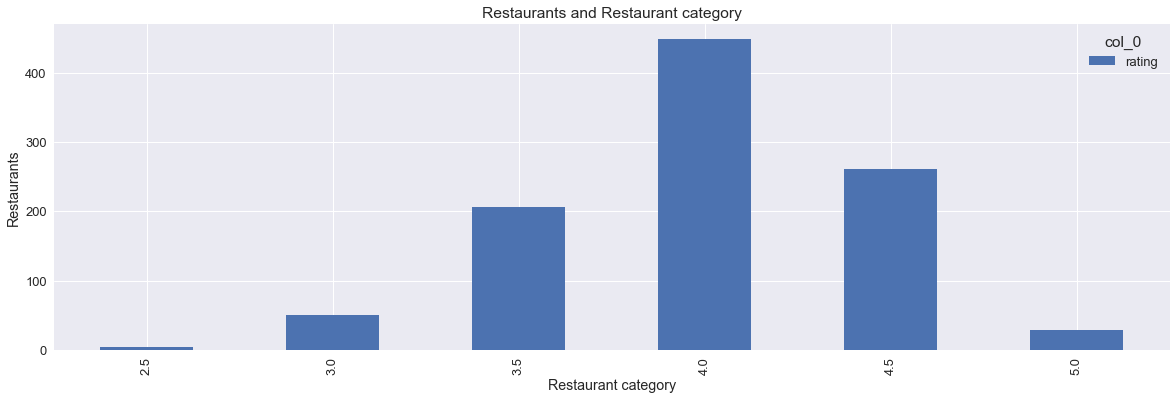

In [67]:
yelp = yelp.sort_values('rating', ascending=False)

sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20,6))
pd.crosstab(yelp.rating,yelp.rating.name).head(20).plot(ax=ax, kind='bar')
plt.title('Restaurants and Restaurant category')
plt.xlabel('Restaurant category')
plt.ylabel('Restaurants')
plt.show()

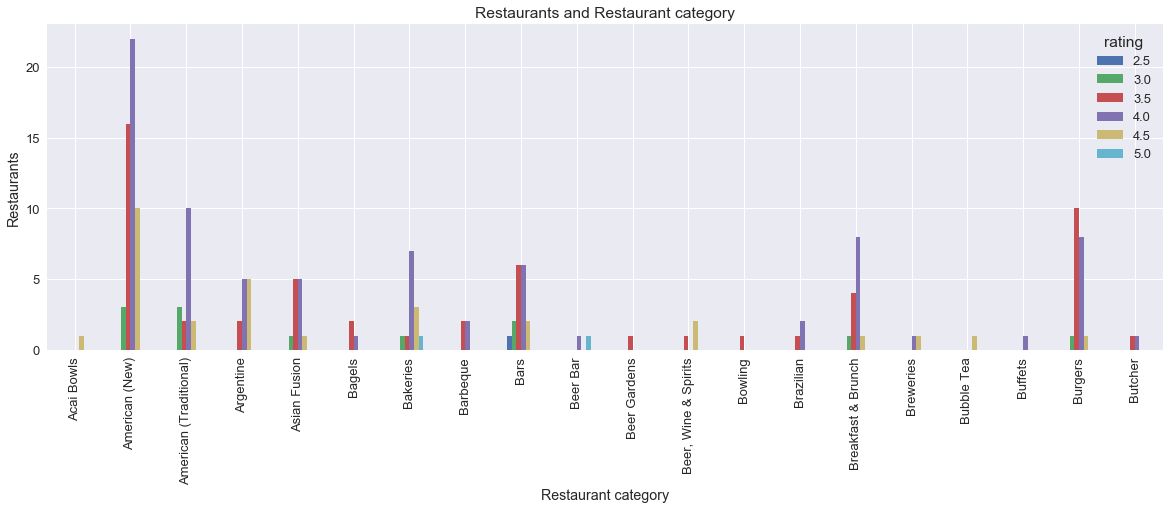

In [68]:
yelp = yelp.sort_values('rating', ascending=False)

sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20,6))
pd.crosstab(yelp.category,yelp.rating).head(20).plot(ax=ax, kind='bar')
plt.title('Restaurants and Restaurant category')
plt.xlabel('Restaurant category')
plt.ylabel('Restaurants')
plt.show()

# Trip Advisor

In [71]:
# There are in total 3600 restaurants
ta.ranking.str[-5:].unique()

array(['3,600', nan], dtype=object)

# Converting the restaurant ranking to rating

In [102]:
# Extracting the ranking for each restaurant

ta['rating'] = ta.ranking.str.split(' ').str[0].str.replace(',','')

In [103]:
# Dividing the restaurants on a scale of 3,600 total restaurants in Miami

ta['rating'] = ta['rating'].astype(float)/3600

In [104]:
# Converting to a 5-scale

ta['ratingpercentile'] = pd.qcut(ta.rating,100, labels=False)

In [105]:
ta['ratingbucket'] = np.where(ta.rating.isnull(), np.nan, 5.0)
ta['ratingbucket'][ta['ratingpercentile'] > 10] = 4.5
ta['ratingbucket'][ta['ratingpercentile'] > 30] = 4.0
ta['ratingbucket'][ta['ratingpercentile'] > 50] = 3.5
ta['ratingbucket'][ta['ratingpercentile'] > 70] = 3.0
ta['ratingbucket'][ta['ratingpercentile'] > 85] = 2.5

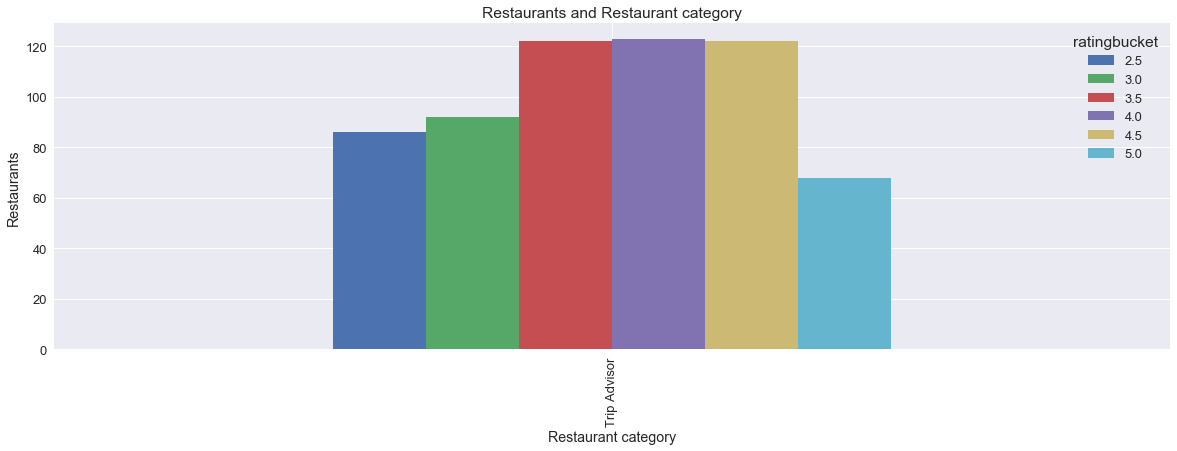

In [106]:
ta = ta.sort_values('rating', ascending=False)

sns.set(font_scale=1.3)
fig, ax = plt.subplots(figsize=(20,6))
pd.crosstab(ta.Source,ta.ratingbucket).plot(ax=ax, kind='bar')
plt.title('Restaurants and Restaurant category')
plt.xlabel('Restaurant category')
plt.ylabel('Restaurants')
plt.show()

In [108]:
zomato.columns = ['zomato_Address', 'zomato_rating', 'zomato_Rating Text', 'name', 'zomato_Url', 'zomato_Votes',
       'zomato_Source','zomato_ratingbucket']

In [109]:
yelp.columns = ['yelp_category', 'name', 'yelp_price', 'yelp_rating', 'yelp_review_count', 'yelp_url', 'yelp_zip','yelp_source']

In [115]:
ta.columns = ['ta_restaurantID', 'ta_restaurantURL', 'name', 'ta_address', 'ta_ranking',
       'ta_total review', 'ta_source', 'ta_rating', 'ta_ratingpercentile', 'ta_ratingbucket']

In [120]:
comb = pd.merge(ta, zomato, how = 'inner', on = 'name')

comb.shape

(3, 17)

In [121]:
comb2 = pd.merge(comb, yelp, how = 'inner', on = 'name')

In [122]:
sns.set(font_scale=1.3)

comb2.plot(kind='bar', x = 'name',y = ['ta_rating','yelp_rating','zomato_rating'], figsize=(15,5))

plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot

In [123]:
comb3 = pd.merge(zomato, yelp, how = 'inner', on = 'name')

In [124]:
sns.set(font_scale=1.3)

comb3.plot(kind='bar', x = 'name',y = ['yelp_rating','zomato_rating'], figsize=(15,5))

plt.show()

TypeError: Empty 'DataFrame': no numeric data to plot